# Feature visualization

Here we use Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA) to visualize the high-dimensional feature space.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
# load the dataset

df = pd.read_pickle("./data/dataset.pkl")

In [3]:
# the function for feature space visualization

def plot(feature, delta_chir_conc, dimensional_reduction, 
         scaling = (1, 1), title = None, axis_label = None, 
         xlim = None, ylim = None, xticks = None, yticks = None, point_size = 60, 
         tick_fontsize = 15, legend_fontsize = 12, title_fontsize = 15, label_fontsize = 15):
    '''
        Plot the feature space.
        
        Args:
        ---------
        feature: 2D array, of shape (#points, #dimensions)
            The high-dimensional feature vectors of each well.
            
        delta_chir_conc: 1D array, of shape (#points, )
            The "ΔCHIR concentration" of each well. 
        
        dimensional_reduction: instance of `sklearn.decomposition.PCA` or 
                                           `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`
            Specifying the dimensional reduction method.
        
        scaling: (int, int)
            The scaling factor for each axis. 
            
        title: str
        axis_label: (str, str)
        xlim, ylim: (float, float)
        xticks, yticks: list of str
    '''
    colormap = {0:[1, 1, 1],
                2:[1, 127/255, 127/255],
                4:[1, 10/255, 10/255],
                6:[180/255, 10/255, 10/255],
                -1: [64/255, 64/255, 1],
                -2: [127/255, 127/255, 1],
                -4: [10/255, 10/255, 180/255]}
    linewidth = {-4: 0.1, -2: 0.1, -1: 0.1, 0: 0.35, 2: 0.1, 4: 0.1, 6: 0.1}
    edgecolor = {-4: "darkblue", -2: "darkblue", -1: "darkblue", 0: "black", 2: "darkred", 4: "darkred", 6: "darkred"}
    
    
    X = np.asarray(feature)
    delta_chir_conc = delta_chir_conc.to_numpy()
    
    if (isinstance(dimensional_reduction, LDA)):
        label = np.sign(delta_chir_conc).astype(np.int32)
        dimensional_reduction = Pipeline([ ("scaler", StandardScaler()),
                                           ("dimension reduction", dimensional_reduction)
                                         ])
        X_r = dimensional_reduction.fit_transform(X, label)
    elif (isinstance(dimensional_reduction, PCA)):
        pca = dimensional_reduction
        dimensional_reduction = Pipeline([ ("scaler", StandardScaler()),
                                           ("dimension reduction", pca)
                                         ])
        X_r = dimensional_reduction.fit_transform(X)
        var0 = pca.explained_variance_ratio_[0]*100
        var1 = pca.explained_variance_ratio_[1]*100
        if axis_label is not None:
            axis_label0 = "%s (%.2f%%)" % (axis_label[0], var0)
            axis_label1 = "%s (%.2f%%)" % (axis_label[1], var1)
            axis_label = (axis_label0, axis_label1)
    else:
        X_r = dimensional_reduction.fit_transform(X)
    
    # scale the axis for better visualization
    X_r[:, 0] *= scaling[0] 
    X_r[:, 1] *= scaling[1]

    # plot the data points
    for i in (0, 2, 4, 6, -2, -4):
        if (X_r[delta_chir_conc==i, :].shape[0] > 0):
            plt.scatter(X_r[delta_chir_conc == i, 0], 
                        X_r[delta_chir_conc == i, 1], 
                        s = point_size, 
                        c = [colormap[i]], 
                        marker="o", 
                        label = "$\Delta$ CHIR = %d" % i,
                        edgecolors = edgecolor[i], 
                        linewidths = linewidth[i]
                       )
    
    # set other attribute of the figure
    plt.legend(loc = "lower right", fontsize = legend_fontsize)
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    if xticks is not None:
        plt.xticks(xticks, fontsize = tick_fontsize)
    if yticks is not None:
        plt.yticks(yticks, fontsize = tick_fontsize)
    if title is not None:
        plt.title(title, fontsize = title_fontsize)
    if axis_label is not None:
        plt.xlabel(axis_label[0], fontsize = label_fontsize)
        plt.ylabel(axis_label[1], fontsize = label_fontsize)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.tight_layout()

## Linear Discriminant Analysis (LDA)

LDA is a supervised dimensional reduction method, which will linearly project the feature space into the most separable 2-D plane. Therefore, we adopt LDA to verify whether the extracted 21-D feature vectors can be used to discriminate among the "low", "optimal", and "high" CHIR concentration groups. 

Here we provide codes to generate the LDA plots for CHIR duration = 24h, 36h, and 48h (**Fig. 4d**). One can see that wells in the "low", "optimal", and "high" CHIR concentration groups can be clearly separated, indicating that the 21-D feature vectors contain enough information for CHIR dose assessment. 

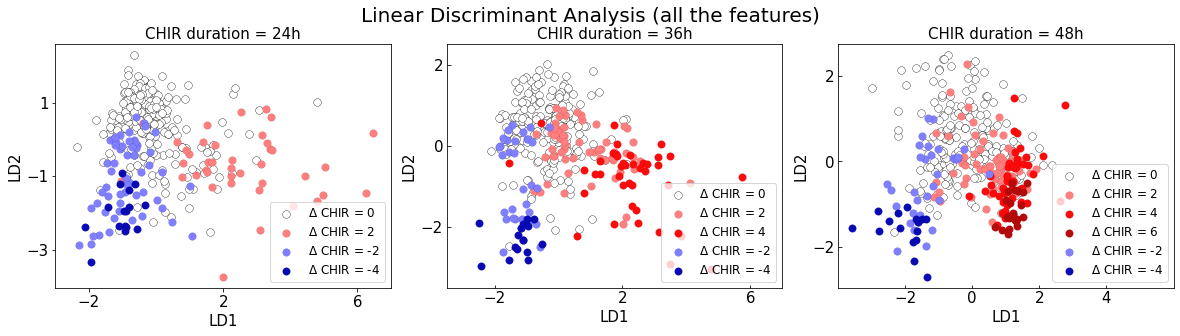

In [4]:
ax = plt.figure(figsize=(16.5, 4.5))

plt.subplot(1, 3, 1)
plot(df.feature.to_list(), df.delta_CHIR_conc_24, 
     dimensional_reduction = LDA(solver = 'eigen', n_components=2, shrinkage = 0.1), 
     scaling = (-1, -1),
     xlim = (-3, 7), 
     xticks = [-2, 2, 6], 
     yticks = [-3, -1, 1],
     axis_label = ("LD1", "LD2"),
     title = "CHIR duration = 24h"
    )

plt.subplot(1, 3, 2)
plot(df.feature.to_list(), df.delta_CHIR_conc_36, 
     dimensional_reduction = LDA(solver = 'eigen', n_components=2, shrinkage = 0.1), 
     scaling = (-1, -1),
     xlim = (-3.5, 7), 
     ylim = (-3.5, 2.5),
     xticks = [-2, 2, 6], 
     yticks = [-2, 0, 2],
     axis_label = ("LD1", "LD2"),
     title = "CHIR duration = 36h"
    )

plt.subplot(1, 3, 3)
plot(df.feature.to_list(), df.delta_CHIR_conc_48, 
     dimensional_reduction = LDA(solver = 'eigen', n_components=2, shrinkage = 0.1), 
     scaling = (1, 1),
     xlim = (-4, 6), 
     xticks = [-2, 0, 2, 4], 
     yticks = [-2, 0, 2],
     axis_label = ("LD1", "LD2"),
     title = "CHIR duration = 48h"
    )

ax.suptitle("Linear Discriminant Analysis (all the features)", fontsize = 20, verticalalignment = "baseline")
plt.show()

## Principal Component Analysis (PCA)

PCA is an unsupervised dimensional reduction method, which will linearly project the high-dimensional feature space to a 2-D plane while maximizing the variance. We used PCA to visualize the sample distribution in the original 21-D feature space.

Here we provide codes to generate the PCA plots for CHIR duration = 24h, 36h, 48h (**Supplementary Fig. S10c**). One can see the the 21-D features actually contain information irrelevant to the class labels, making it hard for the classifier to generalize well with a limited size of training data. This motivate us to perform feature selection.     

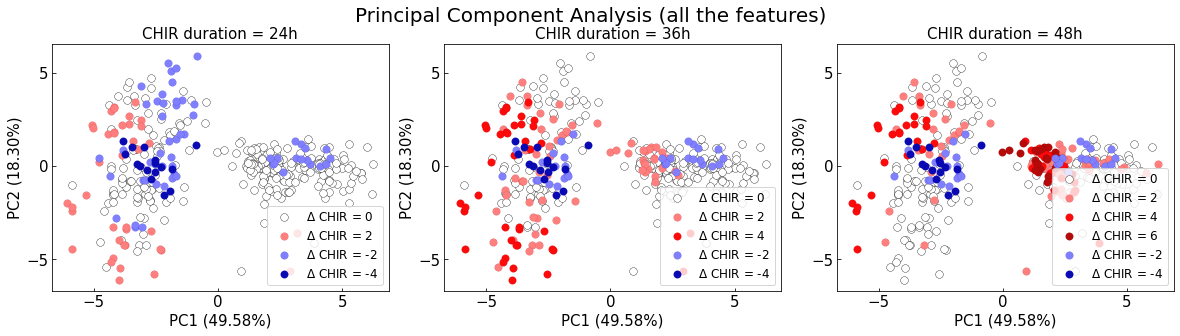

In [5]:
ax = plt.figure(figsize=(16.5, 4.5))

plt.subplot(1, 3, 1)
plot(df.feature.to_list(), df.delta_CHIR_conc_24, 
     dimensional_reduction = PCA(n_components=2, random_state=123), 
     scaling = (1, -1),
     xticks = [-5, 0, 5], 
     yticks = [-5, 0, 5],
     axis_label = ("PC1", "PC2"),
     title = "CHIR duration = 24h"
    )

plt.subplot(1, 3, 2)
plot(df.feature.to_list(), df.delta_CHIR_conc_36, 
     dimensional_reduction = PCA(n_components=2, random_state=123), 
     scaling = (1, -1),
     xticks = [-5, 0, 5], 
     yticks = [-5, 0, 5],
     axis_label = ("PC1", "PC2"),
     title = "CHIR duration = 36h"
    )

plt.subplot(1, 3, 3)
plot(df.feature.to_list(), df.delta_CHIR_conc_48, 
     dimensional_reduction = PCA(n_components=2, random_state=123), 
     scaling = (1, -1),
     xticks = [-5, 0, 5], 
     yticks = [-5, 0, 5],
     axis_label = ("PC1", "PC2"),
     title = "CHIR duration = 48h"
    )

ax.suptitle("Principal Component Analysis (all the features)", fontsize = 20, verticalalignment = "baseline")
plt.show()

## Feature selection

To increase the generalization ability and robustness of the classification, we perform ANOVA-based feature selection. We use the top four features with the highest importance weight to represent each well. The PCA and LDA plots (**Supplementary Fig. S10d, e**) can be generated using the following codes. Please refer to `machine_learning.ipynb` for the classification performance after feature selection.

One can see that feature selection reduces the information redundancy in the original 21-D feature vectors (from the PCA plots), while preserves the disciminative ability (from the LDA plots). 

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

# Feature selection is performed using only the training data.
df_train = pd.read_pickle("./data/dataset_train.pkl")

feature_selector_24 = SelectKBest(f_classif, k = 4)
label_24 = np.sign(df_train.delta_CHIR_conc_24.to_numpy()).astype(np.int32)
feature_selector_24.fit(df_train.feature.to_list(), label_24)

feature_selector_36 = SelectKBest(f_classif, k = 4)
label_36 = np.sign(df_train.delta_CHIR_conc_36.to_numpy()).astype(np.int32)
feature_selector_36.fit(df_train.feature.to_list(), label_36)

feature_selector_48 = SelectKBest(f_classif, k = 4)
label_48 = np.sign(df_train.delta_CHIR_conc_48.to_numpy()).astype(np.int32)
feature_selector_48.fit(df_train.feature.to_list(), label_48)

SelectKBest(k=4)

### PCA (after feature selection)

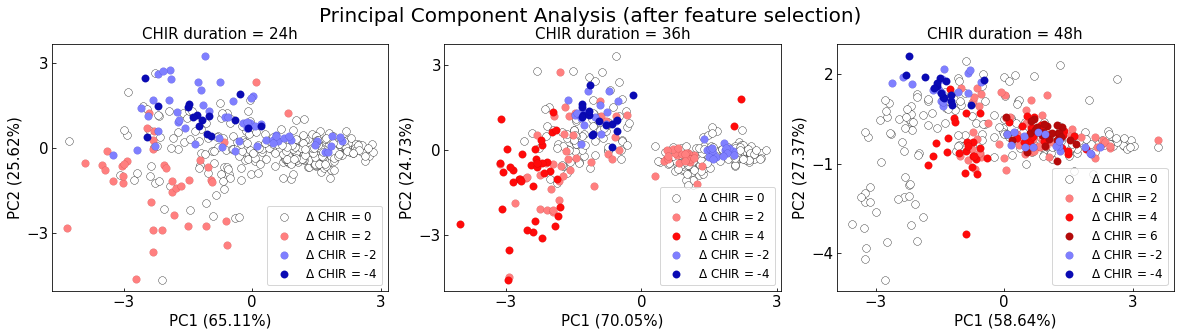

In [7]:
ax = plt.figure(figsize=(16.5, 4.5))

plt.subplot(1, 3, 1)
plot(feature_selector_24.transform(df.feature.to_list()), df.delta_CHIR_conc_24, 
     dimensional_reduction = PCA(n_components=2, random_state=123), 
     scaling = (-1, -1),
     xticks = [-3, 0, 3], 
     yticks = [-3, 0, 3],
     axis_label = ("PC1", "PC2"),
     title = "CHIR duration = 24h"
    )

plt.subplot(1, 3, 2)
plot(feature_selector_36.transform(df.feature.to_list()), df.delta_CHIR_conc_36, 
     dimensional_reduction = PCA(n_components=2, random_state=123), 
     scaling = (-1, -1),
     xticks = [-3, 0, 3], 
     yticks = [-3, 0, 3],
     axis_label = ("PC1", "PC2"),
     title = "CHIR duration = 36h"
    )

plt.subplot(1, 3, 3)
plot(feature_selector_48.transform(df.feature.to_list()), df.delta_CHIR_conc_48, 
     dimensional_reduction = PCA(n_components=2, random_state=123), 
     scaling = (1, -1),
     xticks = [-3, 0, 3], 
     yticks = [-4, -1, 2],
     axis_label = ("PC1", "PC2"),
     title = "CHIR duration = 48h"
    )

ax.suptitle("Principal Component Analysis (after feature selection)", fontsize = 20, verticalalignment = "baseline")
plt.show()

### LDA (after feature selection)

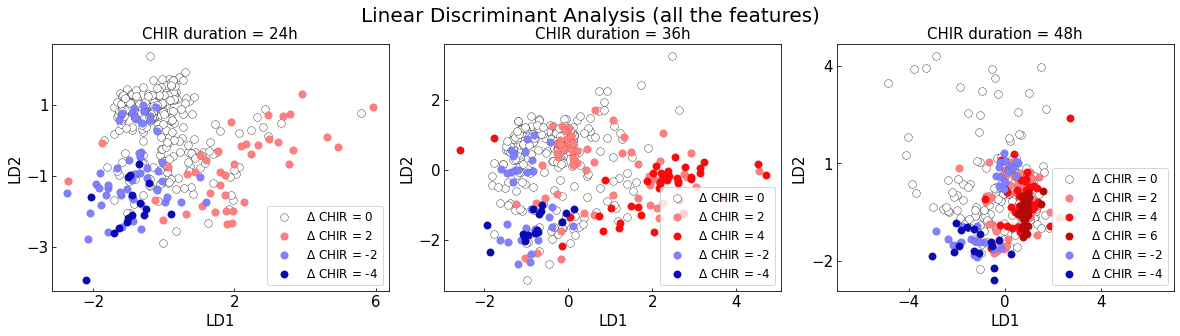

In [8]:
ax = plt.figure(figsize=(16.5, 4.5))

plt.subplot(1, 3, 1)
plot(feature_selector_24.transform(df.feature.to_list()), df.delta_CHIR_conc_24, 
     dimensional_reduction = LDA(solver = 'eigen', n_components=2, shrinkage = 0), 
     scaling = (1, 1),
     xticks = [-2, 2, 6], 
     yticks = [-3, -1, 1],
     axis_label = ("LD1", "LD2"),
     title = "CHIR duration = 24h"
    )

plt.subplot(1, 3, 2)
plot(feature_selector_36.transform(df.feature.to_list()), df.delta_CHIR_conc_36, 
     dimensional_reduction = LDA(solver = 'eigen', n_components=2, shrinkage = 0), 
     scaling = (-1, -1),
     xticks = [-2, 0, 2, 4], 
     yticks = [-2, 0, 2],
     axis_label = ("LD1", "LD2"),
     title = "CHIR duration = 36h"
    )

plt.subplot(1, 3, 3)
plot(feature_selector_48.transform(df.feature.to_list()), df.delta_CHIR_conc_48, 
     dimensional_reduction = LDA(solver = 'eigen', n_components=2, shrinkage = 0), 
     scaling = (-1, 1),
     xlim = (-7, 7), 
     xticks = [-4, 0, 4], 
     yticks = [-2, 1, 4],
     axis_label = ("LD1", "LD2"),
     title = "CHIR duration = 48h"
    )

ax.suptitle("Linear Discriminant Analysis (all the features)", fontsize = 20, verticalalignment = "baseline")
plt.show()